In [1]:
%load_ext cython

In [2]:
%matplotlib inline
import collections
import cv2
import gym
import gzip
import matplotlib.pyplot as plot
import numpy as np
import random
import resource
import seaborn as sns
import time
import torch as t
from IPython.display import clear_output

In [3]:
def get_rss_kb():
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

from https://github.com/higgsfield/RL-Adventure/blob/master/4.prioritized%20dqn.ipynb

In [4]:
%%cython -c=-O3
# cython: boundscheck=False
import numpy as np
cimport numpy as np

from cython.parallel cimport prange
from libc.math cimport pow, exp, log

cdef int _st_get_one_tree_idx(float[:] tree, int capacity, float s) nogil:
    cdef int parent = 0
    cdef int base = capacity - 1
    cdef float lval
    while parent < base:
        parent = parent * 2 + 1
        lval = tree[parent]
        if s > lval and tree[parent+1] > 0:
            s -= lval
            parent += 1
    return parent

cdef void _st_to_prios(float[:] errors, float upper, float alpha) nogil:
    cdef int n = errors.shape[0]
    cdef int i
    cdef float e
    for i in range(n):
        e = errors[i]
        if e < 1e-5:
            e = 1e-5
        if e > upper:
            e = upper
        errors[i] = pow(e, alpha)

cdef void _st_update_one(float[:] tree, int capacity, int data_idx, float value) nogil:
    cdef int i = data_idx + capacity - 1
    cdef float d = value - tree[i]
    while True:
        tree[i] += d
        if 0 == i:
            break
        i = (i - 1) // 2

cdef void _st_update_many(float[:] tree, int capacity, int[:] data_indices, float[:] values) nogil:
    cdef int N = data_indices.shape[0]
    cdef int i
    for i in range(N):
        _st_update_one(tree, capacity, data_indices[i], values[i])

cdef void _st_sample(float[:] tree, int capacity, int n, float[:] in_s, int[:] out_indices, float[:] out_weights):
    cdef int i
    cdef int base = capacity - 1
    assert tree.shape[0] == capacity * 2 - 1, "capacity does not match tree shape"
    assert n == in_s.shape[0], "in_s shape don't match n"
    assert n == out_indices.shape[0], "out_indices shape don't match n"
    assert n == out_weights.shape[0], "out_weights shape don't match n"
    cdef int t_i
    for i in prange(n, nogil=True):
        t_i = _st_get_one_tree_idx(tree, capacity, in_s[i])
        out_indices[i] = t_i - base
        out_weights[i] = tree[t_i]

class PrioritizedBuffer(object):
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_step=1e-4):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_step = beta_step
        
        self.tree = np.zeros((capacity * 2 - 1,), dtype=np.float32)
        self.data = np.empty(capacity, dtype=object)
        self.pos = 0
        self.count = 0

    def __len__(self):
        return self.count
    
    def add(self, obj):
        self.data[self.pos] = obj
        _st_update_one(self.tree, self.capacity, self.pos, 1)
        self.pos = (self.pos + 1) % self.capacity
        if self.count < self.capacity:
            self.count += 1
    
    def update(self, indices, weights):
        _st_to_prios(weights, 1, self.alpha)
        _st_update_many(self.tree, self.capacity, indices, weights)
    
    def sample(self, n):
        weights = np.empty(n, dtype=np.float32)
        indices = np.empty(n, dtype=np.int32)
        segment = self.tree[0] / n
        a = np.arange(n, dtype=np.float32) * segment
        s = np.random.uniform(a, a + segment).astype(np.float32)
        _st_sample(self.tree, self.capacity, n, s, indices, weights)
        self.beta = min(1, self.beta + self.beta_step)
        weights = np.power(weights / self.tree[0] * self.count, -self.beta)
        weights /= weights.max()
        return indices, weights.astype(np.float32), self.data[indices]

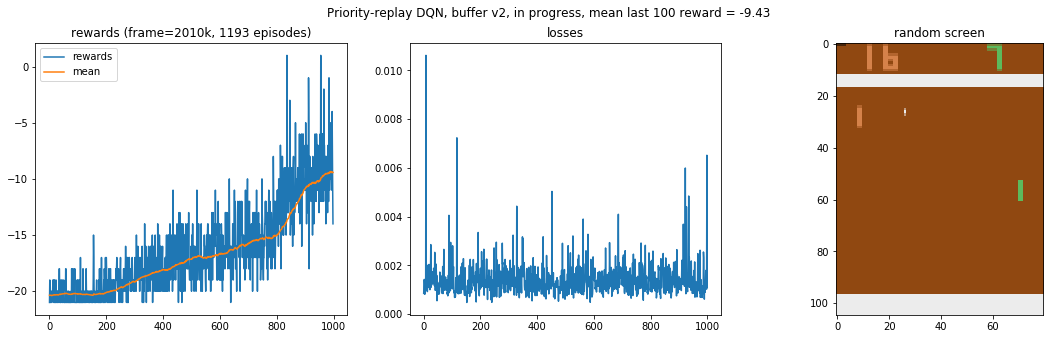

{'run_one_frame': 25510104, 'count: learn': 2009968, 'calc: sample batch': 25336432, 'calc: target': 5856, 'calc: Q': 34676, 'calc: loss': 8, 'run optimizer': 980, 'end of learn': 260, 'count: act': 1870257, 'act: predict action': 2256}
per batch: 12 KiB


In [ ]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not belive how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]))

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = collections.deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]))

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(ResizeObservation, self).__init__(env)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0] // 2, shp[1] // 2, shp[2]))
        self.resize_to = (shp[1] // 2, shp[0] // 2)

    def observation(self, observation):
        return cv2.resize(observation, self.resize_to, interpolation=cv2.INTER_AREA)

SUFFIX = 'Deterministic-v4'
env = gym.make('Pong' + SUFFIX)
env = ResizeObservation(env)
env = ImageToPyTorch(env)
env = FrameStack(env, 4)

USE_CUDA = t.cuda.is_available()# and False
device = t.device('cuda') if USE_CUDA else t.device('cpu')

class Model(t.nn.Module):
    def __init__(self, input_shape, input_frames, n_out):
        super().__init__()
        self.cnn = t.nn.Sequential(
            t.nn.Conv2d(3 * input_frames, 32, kernel_size=8, stride=4),
            t.nn.PReLU(),
            t.nn.Conv2d(32, 64, kernel_size=4, stride=2),
            t.nn.PReLU(),
            t.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            t.nn.PReLU(),
        ) # -> 64 9 6
        cnn_fc = self.feature_size(self.cnn, input_shape)
        self.fc = t.nn.Sequential(
            t.nn.Linear(cnn_fc, 512),
            t.nn.PReLU(),
            t.nn.Linear(512, n_out)
        )
        self.apply(self.weights_init)
    
    def feature_size(self, cnn, shape):
        return cnn(t.zeros(1, *shape)).view(1, -1).size(1)

    def weights_init(self, m):
        if False:
            if isinstance(m, t.nn.Linear):
                t.nn.init.kaiming_normal_(m.weight, 2)
                t.nn.init.constant_(m.bias, 0)
            elif isinstance(m, t.nn.Conv2d):
                t.nn.init.kaiming_normal_(m.weight, 2)
                t.nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
        p = self.cnn.forward(x)
        p = p.view(p.size(0), -1)
        return self.fc.forward(p)

'''class Replay(object):
    def __init__(self, maxlen):
        self.memory = Memory(maxlen)
    def __len__(self):
        return len(self.memory)
    def add(self, state, action, next_state, reward, done):
        self.memory.add((state, action, next_state, reward, done))
    def sample(self, n):
        states, actions, next_states, rewards, masks = zip(*self.memory.sample(n)[1])#.tolist()
        actions = t.as_tensor(actions, dtype=t.long, device=device)
        rewards = t.as_tensor(rewards, dtype=t.float, device=device)
        masks = t.as_tensor(masks, dtype=t.float, device=device)
        states = Replay.stack_states(states)
        next_states = Replay.stack_states(next_states)
        return states, actions, next_states, rewards, masks
    @staticmethod
    def stack_states(states):
        s = np.concatenate([np.expand_dims(np.array(x), 0) for x in states])
        return t.as_tensor(s, dtype=t.float, device=device)
'''

def build_model():
    return Model(env.observation_space.shape, 4, env.action_space.n).to(device)

def reset_env(env):
    state = env.reset()
    if 'FIRE' in env.unwrapped.get_action_meanings():
        state, _, _, _ = env.step(env.unwrapped.get_action_meanings().index('FIRE'))
    return state

def stack_states(states, device):
    s = np.concatenate([np.expand_dims(x, 0) for x in states])
    return t.as_tensor(s, dtype=t.float, device=device)

class Main(object):
    def __init__(self, env):
        self.model = build_model()
        self.opt =  t.optim.Adam(self.model.parameters(), lr=1e-6)
        self.loss_fn = t.nn.SmoothL1Loss()

        self.replay = PrioritizedBuffer(int(1e6))
        self.env = env
        self.eps = 1
        self.eps_final = 0.01
        self.eps_steps = 100000
        self.initial_explore = 100000
        self.eps_decay = np.exp(np.log(self.eps_final / self.eps) / self.eps_steps)
        
        self.all_rewards = []
        self.mean_rewards = []
        self.losses = []
        
        self.batch_size = 32
        self.gamma = 0.99
        self.episode = 0
        self.frame = 0
        
        self.mem_allocs = collections.defaultdict(lambda:0)
    
    def act(self, state):
        if self.frame > self.initial_explore:
            self.eps = self.eps * self.eps_decay
            if self.eps < self.eps_final:
                self.eps = self.eps_final

        if self.frame < self.initial_explore or random.random() < self.eps:
            action = np.random.randint(self.env.action_space.n)
        else:
            m = get_rss_kb()
            self.mem_allocs['count: act'] += 1

            self.model.eval()
            with t.no_grad():
                state = t.as_tensor(np.array(state), dtype=t.float, device=device)
                q = self.model(state).detach()
                action = int(q.argmax().item())
                del state, q
                self.mem_allocs['act: predict action'] += get_rss_kb() - m; m = get_rss_kb()
        return action
    
    def run_episode(self):
        self.all_rewards.append(0)
        if len(self.all_rewards) > 1000:
            self.all_rewards = self.all_rewards[1:]
        self.mean_rewards.append(0)
        if len(self.mean_rewards) > 1000:
            self.mean_rewards = self.mean_rewards[1:]
        state, done = reset_env(self.env), False

        while not done:
            m = get_rss_kb()
            self.frame += 1
            action = self.act(state)
            next_state, reward, done, info = env.step(action)
            assert isinstance(reward, float), 'reward must be a number!'
            self.all_rewards[-1] += reward
            self.replay.add((state, action, next_state, reward, done))
            state = next_state

            if len(self.replay) > self.batch_size:
                self.learn_on_replay()

            if self.frame % 10000 == 0:
                self.plot_state('in progress')
            self.mem_allocs['run_one_frame'] += get_rss_kb() - m

        self.mean_rewards[-1] = np.mean(np.array(self.all_rewards)[-100:])
        solved = len(self.all_rewards) > 100 and self.mean_rewards[-2] > 18
        return solved
    
    def run(self, episodes):
        while self.episode < episodes:
            self.episode += 1
            solved = self.run_episode()
            if solved:
                break
        self.plot_state('solved' if solved else 'finished')

        if solved:
            import gzip
            with gzip.open('model-pong-priority-replay-v2-dqn.gz', 'wb') as f:
                t.save(self.model.state_dict(), f, pickle_protocol=4)

    def plot_state(self, msg):
        clear_output(False)
        plot.figure(figsize=(19,5))
        mean_reward = 0 if len(self.mean_rewards) < 2 else self.mean_rewards[-2]
        plot.suptitle(f'Priority-replay DQN, buffer v2, {msg}, mean last 100 reward = {mean_reward}')
        plot.subplot(131)
        plot.title('rewards (frame=%dk, %d episodes)' % (np.round(self.frame/1000), self.episode))
        plot.plot(self.all_rewards[:-1], label='rewards')
        plot.plot(self.mean_rewards[:-1], label='mean')
        plot.legend()
        plot.subplot(132)
        plot.title('losses')
        plot.plot(self.losses)
        plot.subplot(133)
        plot.title('random screen')
        i, w, samples = self.replay.sample(1)
        state, a, b, c, d = zip(*samples)
        state = stack_states(state, device)
        plot.imshow(state.squeeze(0)[-3:].permute(1, 2, 0).cpu().numpy() / 255)
        del state, a, b, c, d
        plot.savefig('state-pong-priority-replay-v2-dqn.png', format='png')
        plot.show()
        plot.close()
        print(dict(self.mem_allocs))
        print('per batch:', self.mem_allocs['calc: sample batch'] // self.mem_allocs['count: learn'], 'KiB')

    def learn_on_replay(self):
        m = get_rss_kb()
        self.mem_allocs['count: learn'] += 1
        assert m < 64 * 1024 * 1024, 'ate more than 64 GiB!!!'

        with t.no_grad():
#            self.model.eval()
            indices, weights, samples = self.replay.sample(self.batch_size)
            states, actions, next_states, rewards, masks = zip(*samples)
            states = stack_states(states, device)
            next_states = stack_states(next_states, device)
            actions = t.as_tensor(actions, dtype=t.long, device=device)
            rewards = t.as_tensor(rewards, dtype=t.float, device=device)
            masks = t.as_tensor(masks, dtype=t.float, device=device)
            weights = t.as_tensor(weights, dtype=t.float, device=device)
            
            self.mem_allocs['calc: sample batch'] += get_rss_kb() - m; m = get_rss_kb()

            q_next_value = self.model(next_states).max(1).values
            target = rewards + self.gamma * (1 - masks) * q_next_value
            target.detach_()
            del next_states, rewards, masks, q_next_value
            t.cuda.empty_cache()
        self.mem_allocs['calc: target'] += get_rss_kb() - m; m = get_rss_kb()

        self.model.train()
        q_value = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        del states, actions
        self.mem_allocs['calc: Q'] += get_rss_kb() - m; m = get_rss_kb()

        #loss = self.loss_fn(q_value, target)
        loss = (q_value - target).pow(2) * weights
        prios = loss + 1e-5
        self.replay.update(indices, prios.detach().cpu().numpy())
        del q_value, target, prios
        loss = loss.mean()
        self.mem_allocs['calc: loss'] += get_rss_kb() - m; m = get_rss_kb()

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        self.mem_allocs['run optimizer'] += get_rss_kb() - m; m = get_rss_kb()

        self.losses.append(loss.detach().item())
        del loss
        if len(self.losses) > 1000:
            self.losses = self.losses[1:]
        
        self.mem_allocs['end of learn'] += get_rss_kb() - m; m = get_rss_kb()

main = Main(env)
main.run(10000)

In [ ]:
main.frame